# Guided Project : Answering Business Questions Using SQL

In [1]:
#Importing necessary modules
import pandas as pd
import numpy as np
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def run_query(query):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(query,conn)

def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Finding Highest Selling Genre in US
Writing a query to help us decide which Artist we should purchase for our stores based on genre sales

Options :

Regal	Hip-Hop

Red Tone	Punk

Meteor and the Girls	Pop

Slim Jim Bites	Blues

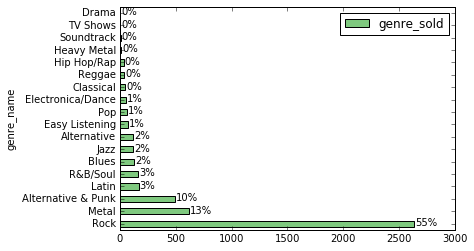

In [4]:
query = '''
WITH sold AS
    (SELECT SUM(il.quantity) total_sold
    FROM invoice_line il)

SELECT 
    g.name genre_name, 
    SUM(il.quantity) genre_sold,
    CAST(SUM(il.quantity) as float)/CAST((SELECT * FROM sold) as float)*100 percentage_of_total
FROM genre g  
    LEFT JOIN track t ON g.genre_id = t.genre_id
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    GROUP BY 1
    ORDER BY 2 DESC
'''
genre_sold_total = run_query(query)
genre_sold_total.set_index("genre_name",drop=True,inplace=True)

fig = plt.figure()
genre_sold_total[['genre_sold']].plot.barh(colormap=plt.cm.Accent)

for i, label in enumerate(list(genre_sold_total.index)):
    score = genre_sold_total.loc[label, "genre_sold"]
    label = (genre_sold_total.loc[label, "percentage_of_total"]
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

Rock is hands-down the most popular selling genre. Out of the available genres for the 4 artist we could purchase, Alternative & Punk is the highest selling.

We should purchase Red Tone based on this data

## Total Sale Amount per Agent

In [5]:
query = '''
WITH sales_agents AS
    (
        SELECT 
            e1.first_name || ' ' || e1.last_name Sales_Agent,
            e1.title title,
            e2.first_name || ' ' || e2.last_name Manager,
            e1.employee_id agent_id
        FROM employee e1 
            LEFT JOIN employee e2 ON e1.employee_id = e2.reports_to
        WHERE e1.title = 'Sales Support Agent'
    ),
    
sa_customers AS
    (
        SELECT
            s.*,
            c.customer_id customer_id
        FROM customer c 
            LEFT JOIN sales_agents s ON c.support_rep_id = s.agent_id
    )
    
SELECT
    s.Sales_Agent,
    s.title,
    SUM(i.total) total_sold
FROM sa_customers s 
    LEFT JOIN invoice i ON s.customer_id = i.customer_id 
GROUP BY s.Sales_Agent
'''

run_query(query)

,Sales_Agent,title,total_sold
0,Jane Peacock,Sales Support Agent,1731.51
1,Margaret Park,Sales Support Agent,1584.00
2,Steve Johnson,Sales Support Agent,1393.92


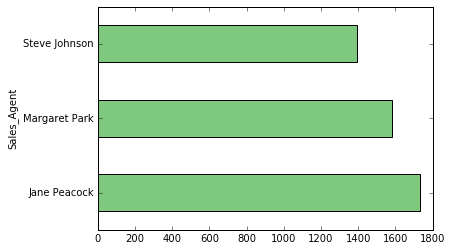

In [6]:
sales_by_agent = run_query(query)
sales_by_agent.set_index("Sales_Agent",drop=True,inplace=True)

sales_by_agent.plot.barh(colormap=plt.cm.Accent,legend=False)

Jane Peacock had the highest sales by roughly 20%

In [7]:
q = '''
WITH customer_agg AS
(
SELECT
    CASE WHEN
        (SELECT COUNT(*)
        FROM customer
        WHERE country = c.country
        GROUP BY country) = 1 THEN 'Other'
        ELSE c.country
        END AS country,
    COUNT(distinct c.customer_Id) customer_count,
    SUM(i.total) total_sales,
    CAST(SUM(i.total)/COUNT(distinct c.customer_Id) as float) average_value,
    SUM(i.total)/COUNT(i.invoice_id) average_order,
    SUM(i.total)/COUNT(distinct c.customer_id) sales_per_customer
FROM 
    customer c 
    INNER JOIN invoice i ON c.customer_id = i.customer_id
GROUP BY 1
ORDER BY 2 DESC
)

SELECT *
FROM
    (
    SELECT ca.*,
    CASE
        WHEN ca.country = 'Other' THEN 1
        ELSE 0
    END AS sort
    FROM customer_agg ca)
ORDER BY sort ASC
'''

country_sales = run_query(q)
country_sales.set_index("country",drop=True,inplace=True)
country_sales

,customer_count,total_sales,average_value,average_order,sales_per_customer,sort
country,,,,,,
USA,13,1040.49,80.037692,7.942672,80.037692,0
Canada,8,535.59,66.948750,7.047237,66.948750,0
Brazil,5,427.68,85.536000,7.011148,85.536000,0
France,5,389.07,77.814000,7.781400,77.814000,0
Germany,4,334.62,83.655000,8.161463,83.655000,0
United Kingdom,3,245.52,81.840000,8.768571,81.840000,0
Czech Republic,2,273.24,136.620000,9.108000,136.620000,0
India,2,183.15,91.575000,8.721429,91.575000,0
Portugal,2,185.13,92.565000,6.383793,92.565000,0


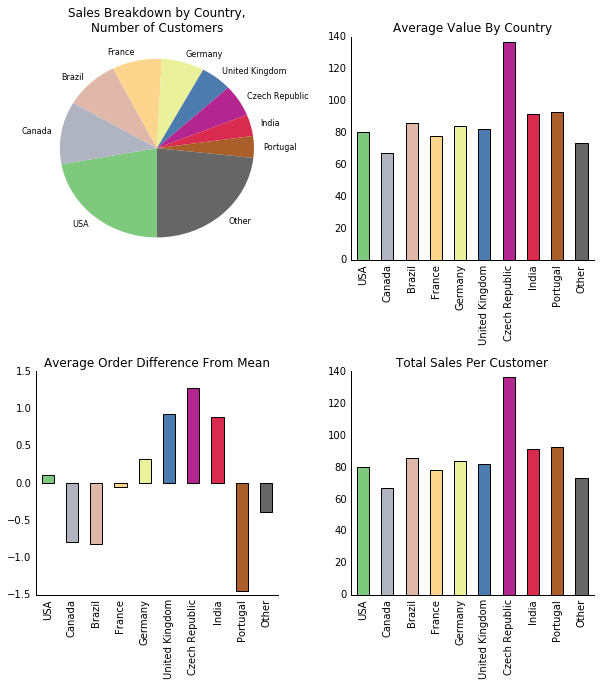

In [8]:
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_sales.shape[0])]

fig, axes = plt.subplots(2,2,figsize=(10,10))
ax1,ax2,ax3,ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


#Total Sales Pie Chart
country_sales['total_sales'].plot.pie(ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0})
ax1.get_yaxis().set_visible(False)


#Average Value By Country Graph
country_sales['average_value'].plot.bar(ax=ax2,
    color=colors,
    title='Average Value By Country')
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.xaxis.label.set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

#Difference From Mean Graph
country_sales['diff_from_mean'] = country_sales['average_order'] - country_sales['average_order'].mean()
country_sales['diff_from_mean'].plot.bar(ax=ax3,
        color=colors,
        title='Average Order Difference From Mean')
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.xaxis.label.set_visible(False)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)

#Sales Per Customer
country_sales['sales_per_customer'].plot.bar(ax=ax4,
        color=colors,
        title='Total Sales Per Customer')
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.xaxis.label.set_visible(False)
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

Based on the data above we'd get the most value out of advertising to get mor ecustomers in Czech Republic, United Kingdom, and India. 

In [43]:
q = '''
WITH full_album AS
(SELECT 
    i.invoice_id, 
    il.track_id, 
    t.album_id,
    CASE WHEN
        (
            (
                SELECT 
                    track_id
                FROM 
                    invoice_line
                WHERE 
                    invoice_id = i.invoice_id
                EXCEPT
                SELECT 
                    track_id
                FROM 
                    track
                WHERE 
                    album_id = t.album_id
                ) IS NULL

                AND

                (
                    SELECT 
                        track_id
                    FROM 
                        track
                    WHERE 
                        album_id = t.album_id
                    EXCEPT
                    SELECT 
                        track_id
                    FROM
                        invoice_line
                    WHERE 
                        invoice_id = i.invoice_id
                ) IS NULL
            ) THEN "Yes"
            ELSE "No"
            END AS full_album_bool
    
FROM
    invoice i
    INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
    INNER JOIN track t ON il.track_id = t.track_id
)

SELECT
    full_album_bool "Full Album Purchased",
    COUNT(distinct invoice_id) "Invoice Count",
    CAST(COUNT(distinct invoice_id) as float) / (SELECT COUNT (*) FROM invoice) percent
FROM
    full_album
GROUP BY 1
'''

run_query(q)

,Full Album Purchased,Invoice Count,percent
0,No,500,0.814332
1,Yes,114,0.185668


I think Chinook should continue to buy full albums. Although the majority of customers buy single tracks, full albums still accounts for 1/5 of sales.